In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import numpy as np
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

# 데이터 피쳐 확인

In [5]:
train.shape, test.shape # 둘의 피처 개수가 서로 다르네? 왜 다른지 확인해보자

((10886, 12), (6493, 9))

In [6]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


피쳐 설명
- 1. season : 계절(1:봄, 2:여름, 3:가을, 4:겨울)
- 2. holiday : 공휴일 여부(0:공휴일 아님, 1:공휴일)
- 3. weather : 날씨(숫자가 클수록 날씨 안 좋음)
- 4. casual : 등록되지 않은 사용자 수
- 5. count : 자전거 대여 수량 → **예측해야할 타깃값**

In [7]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


피쳐 설명
 - casual, registered 피쳐 없음 : 모델을 훈련할 때 훈련 데이터의 **해당 피쳐를 제외**해야 함
 - count 피쳐 없음 : 예측해야할 타깃값

In [8]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


피처 설명
 - datetime : 데이터를 구분하는 역할만 하는 ID값으로 타깃값을 예측하는데 아무런 도움 없음 → 훈련 데이터의 해당 피쳐 제외

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


 - 훈련 데이터에는 결측값 없음
 - 데이터 타입 다양 : object(판다스에서의 문자열과 같음), int64, float64

# 피쳐 엔지니어링
 - datetime 피처를 의미있는 파생 피처로 나누기
 - 머신러닝 모델훈련에 적합한 타입으로 변경

In [10]:
# datetime의 100번째 요소를 예로 들어 변경해보자
print(train['datetime'][100]) # object 타입(판다스의 문자열)
print(train['datetime'][100].split()) # 공백을 기준으로 문자열 나누기
print(train['datetime'][100].split()[0]) # 날짜
print(train['datetime'][100].split()[1]) # 시간

2011-01-05 09:00:00
['2011-01-05', '09:00:00']
2011-01-05
09:00:00


 - '2011-01-05' 문자열 → 연도, 월, 일로 나누기

In [11]:
print(train['datetime'][100].split()[0]) # 날짜
print(train['datetime'][100].split()[0].split('-')) # '-' 기준으로 문자열 나누기
print(train['datetime'][100].split()[0].split('-')[0]) # 연도
print(train['datetime'][100].split()[0].split('-')[1]) # 월
print(train['datetime'][100].split()[0].split('-')[2]) # 일

2011-01-05
['2011', '01', '05']
2011
01
05


 - '09:00:00' 문자열 → 시,분,초로 나누기

In [12]:
print(train['datetime'][100].split()[1]) # 시간
print(train['datetime'][100].split()[1].split(':')) # ':' 기준으로 문자열 나누기
print(train['datetime'][100].split()[1].split(':')[0]) # 시간
print(train['datetime'][100].split()[1].split(':')[1]) # 문
print(train['datetime'][100].split()[1].split(':')[2]) # 초

09:00:00
['09', '00', '00']
09
00
00


 - datetime 피처에서 날짜,연도,월,일,시,분,초 파생피처를 차례로 생성

In [13]:
# 각 요소를 split() 할수 있었다.
# 각 피처 전체 요소(Series)에 split() 함수를 적용하려면 : apply()
train['date'] = train['datetime'].apply(lambda x : x.split()[0]) # 날짜 피처 생성
train['year'] = train['datetime'].apply(lambda x : x.split()[0].split('-')[0]) # 연도 피처 생성
train['month'] = train['datetime'].apply(lambda x : x.split()[0].split('-')[1]) # 월 피처 생성
train['day'] = train['datetime'].apply(lambda x : x.split()[0].split('-')[2]) # 일 피처 생성
train['hour'] = train['datetime'].apply(lambda x : x.split()[1].split(':')[0]) # 시 피처 생성
train['minute'] = train['datetime'].apply(lambda x : x.split()[1].split(':')[1]) # 분 피처 생성
train['second'] = train['datetime'].apply(lambda x : x.split()[1].split(':')[2]) # 분 피처 생성

In [14]:
train.head() # 파생 피처들 순서대로 오른쪽에 쌓임

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00


In [15]:
# 요일 피처 생성
from datetime import datetime
import calendar

print(train['date'][100]) # 날짜 피처의 100번째 요소 : object(str 타입)
print(datetime.strptime(train['date'][100], '%Y-%m-%d')) # strptime(자료형 변환) : str → datetime
print(datetime.strptime(train['date'][100], '%Y-%m-%d').weekday()) # weekday() : datetime의 날짜를 요일(int)로 반환
print(calendar.day_name[datetime.strptime(train['date'][100], '%Y-%m-%d').weekday()]) # calendar.day_name : int → 요일(str)

2011-01-05
2011-01-05 00:00:00
2
Wednesday


- 0: 월요일
- 그래프로 시각화 할 때 요일을 쉽게 알아보기 위해 문자열(str)로 변환한 것
- **모델 훈련시 피처값을 문자열로 바꾸면 안됨 : 머신러닝 모델은 숫자만 인식(연산가능)**

 - weekday 피처 생성 : 0 → Sunday 의미가 잘 들어나도록

In [16]:
# apply()함수에 사용되는 lambda 함수 사용의 다른 예
train['weekday'] = train['date'].apply(lambda x : calendar.day_name[datetime.strptime(x, '%Y-%m-%d').weekday()])

 - season 피처 변경  : 1 → Spring
 - weather 피처 변경 : 1 → Clear


In [17]:
# 딕셔너리를 통해 값을 매핑하려면 map() 함수 사용해야 한다(apply() 적용 불가)
train['season'] = train['season'].map({1:'Spring',
                                      2:'Summer',
                                      3:'Fall',
                                      4:'Winter'})
train['weather'] = train['weather'].map({1:'Clear',
                                        2:'Mist, Few clouds',
                                        3:'Light Snow, Rain, Thunderstorm',
                                        4:'Heavy Rain, Thunderstorm, snow, Fog'})

In [18]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


 지나치게 세분화된 피처를 더 큰 분류로 묶으면 성능이 좋아질 수 있음
 - date피처가 year,month,day피처로 나눠졌으므로 date 피처 삭제
 - month피처를 3달씩 묶으면 season 피처가 되므로 month 피처 삭제
 
학습데이터(1일부터19일)와 테스트데이터(20일부터월말) 간에 day 피처에서 공통된 값이 없으므로 사용 불가
 - day 피처 삭제
 
아무런 정보를 갖고 있지 않은 피처 삭제
 - minute, second 피처 삭제

# 데이터 시각화

In [19]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

### 분포도
 - 수치형 데이터의 집계 값을 나타내는 그래프

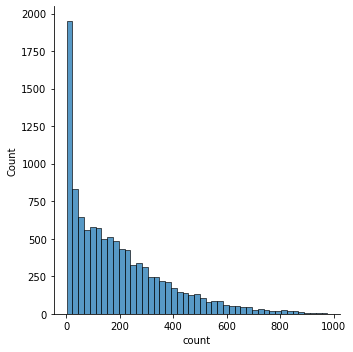

In [20]:
sns.displot(train['count'])

 - 타깃값인 count가 0근처에 몰려있다 : 분포가 왼쪽으로 편향
 - **회귀 모델이 좋은성능을 내려면 타깃값 데이터가 정규분포를 따라야 한다**
 - 로그변환 : 데이터 분포를 정규분포로 만들어주는 가장 많이 사용하는 방법
 - 지수변환 : 마지막에 지수변환을 하여 실제 타깃값인 count로 복원해야 함

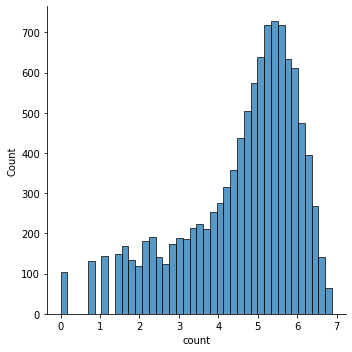

In [21]:
sns.displot(np.log(train['count']))

 - 기존 데이터 분포 보다 정규분포에 가까워짐 → 회귀모델 성능 향상

### 막대 그래프
 - 범주형 데이터에 따른 수치형 데이터(집계 값)를 나타내는 그래프
 - 각 피처(범주형 데이터)에 따라 타깃 값이 어떻게 다른지 파악(중요한 피처 확인)

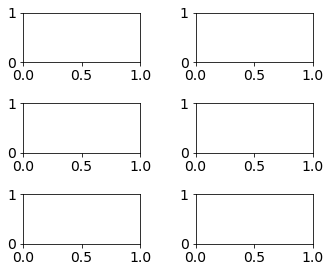

In [22]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(5, 4)) # 3행 2열 10X9 사이즈 Figure 생성
# nrows, ncols 파라미터 없이 3,2 가능
plt.tight_layout() # 서브플롯 간 공간이 넉넉해짐

In [23]:
axes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcea0c837d0>,
      dtype=object)

In [24]:
axes.shape

(3, 2)

 - 3행 2열로 구성된 배열

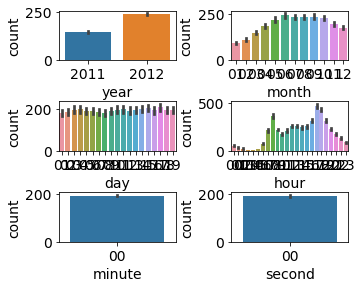

In [25]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(5, 4)) # 3행 2열 10X9 사이즈 Figure 생성
# nrows, ncols 파라미터 없이 3,2 가능
plt.tight_layout() # 서브플롯 간 공간이 넉넉해짐

x = [['year','month'],['day','hour'],['minute','second']]
x = np.array(x)

for i in range(3):
    for j in range(2):
        sns.barplot(x=x[i,j], y='count', data=train, ax=axes[i, j]) # seaborn을 axes각 객체에 할당하려면 ax파라미터 사용

 - minute, second 피처는 count와 상관없으므로 피처 삭제

### 박스플롯
 - 범주형 데이터(계절, 날씨, 공휴일, 근무일)에 따른 수치형 데이터(집계 값)를 나타내는 그래프
 - 막대 그래프 보다 많은 정보 제공

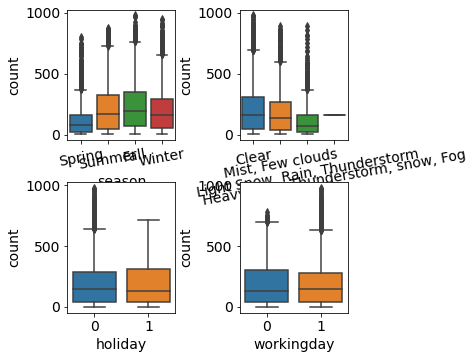

In [26]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5)) # 5행 5열 5X5 사이즈 Figure 생성
# nrows, ncols 파라미터 없이 2,2 가능
plt.tight_layout() # 서브플롯 간 공간이 넉넉해짐

x = [['season','weather'],['holiday','workingday']]
x = np.array(x)

for i in range(2):
    for j in range(2):
        sns.boxplot(x=x[i,j], y='count', data=train, ax=axes[i, j]) # seaborn을 axes각 객체에 할당하려면 ax파라미터 사용
        axes[0, j].tick_params(axis='x', labelrotation=10) # axes[i, j]에 사용가능한 메서드가 따로 있음 : dir(axes[i,j])로 확인


 - 자전거 대여 수랴은 봄에 가장 적고, 가을에 가장 많음
 - 날씨가 좋을때 많음
 - 공휴일(holiday:0), 근무일이 아닌날(공휴일+주말)(workingday:1)에 이상치가 많음

### 포인트 플롯
 - 시간대별 평균 대여 수량을 근무일/공휴일/요일/계절/날씨에 따라 플롯

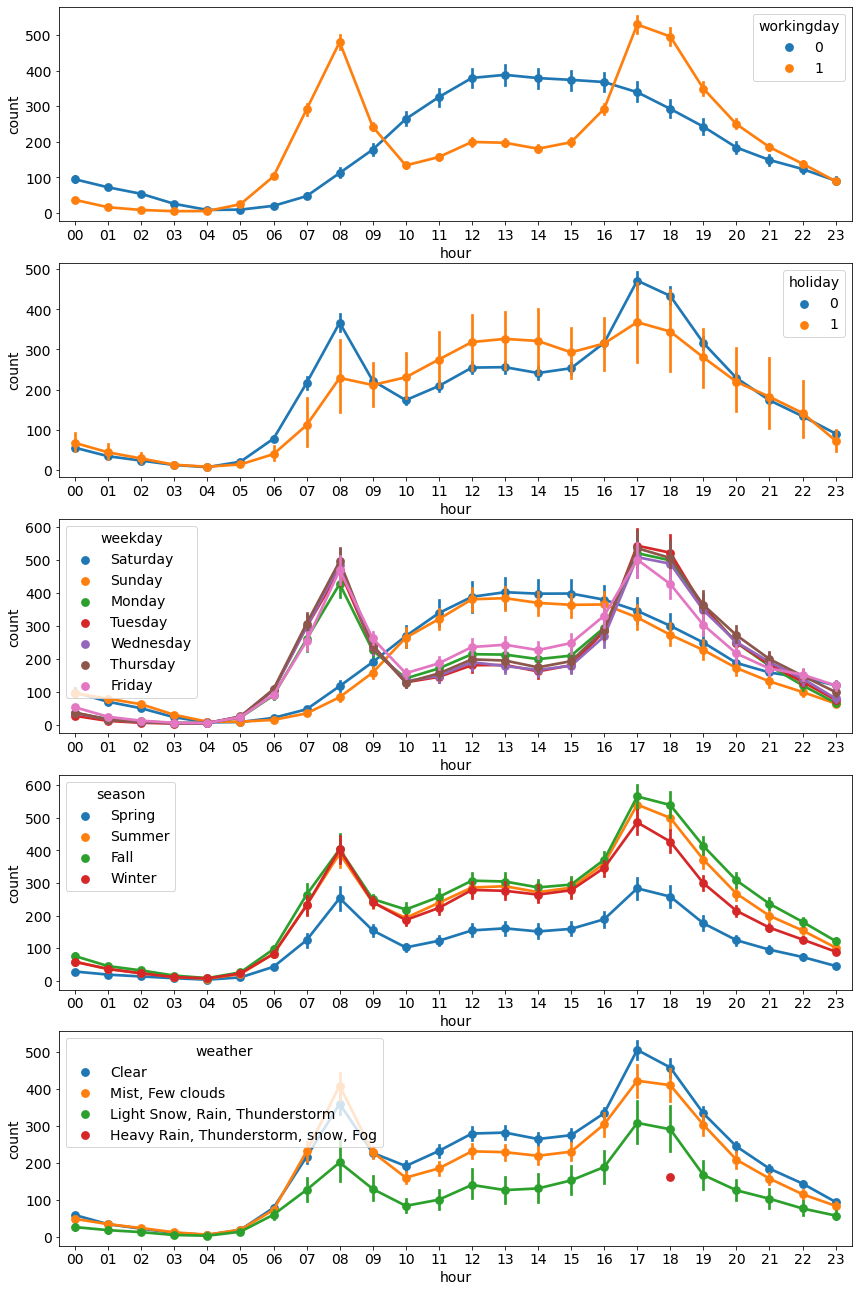

In [27]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=5, figsize=(12, 18)) # 5행 1열 12X18 사이즈 Figure 생성
# ncols 파라미터 1인경우 생략가능 : 생략하든 안하든 axes.shape() → (5,)
plt.tight_layout() # 서브플롯 간 공간이 넉넉해짐

hue = ['workingday','holiday','weekday','season','weather']

for n, i in enumerate(hue):
    sns.pointplot(x='hour', y='count', data=train, hue=i, ax=axes[n]) # seaborn을 axes각 객체에 할당하려면 ax파라미터 사용


 - 근무일에는 출퇴근 시간에 대여 수량 많음
 - 쉬는날에는 오후12시부터 2시사이 가장 많음
 - 가을에 가장 많고, 봄에 가장 적음
 - 폭우, 폭설이 내릴때 18시에 대여건 : **이상치(제거시 최종 모델 성능 향상)**

### 회귀선을 포함한 산점도 그래프
 - 수치형 데이터 간 상관관계 파악 용이
 - seaborn의 regplot() 사용

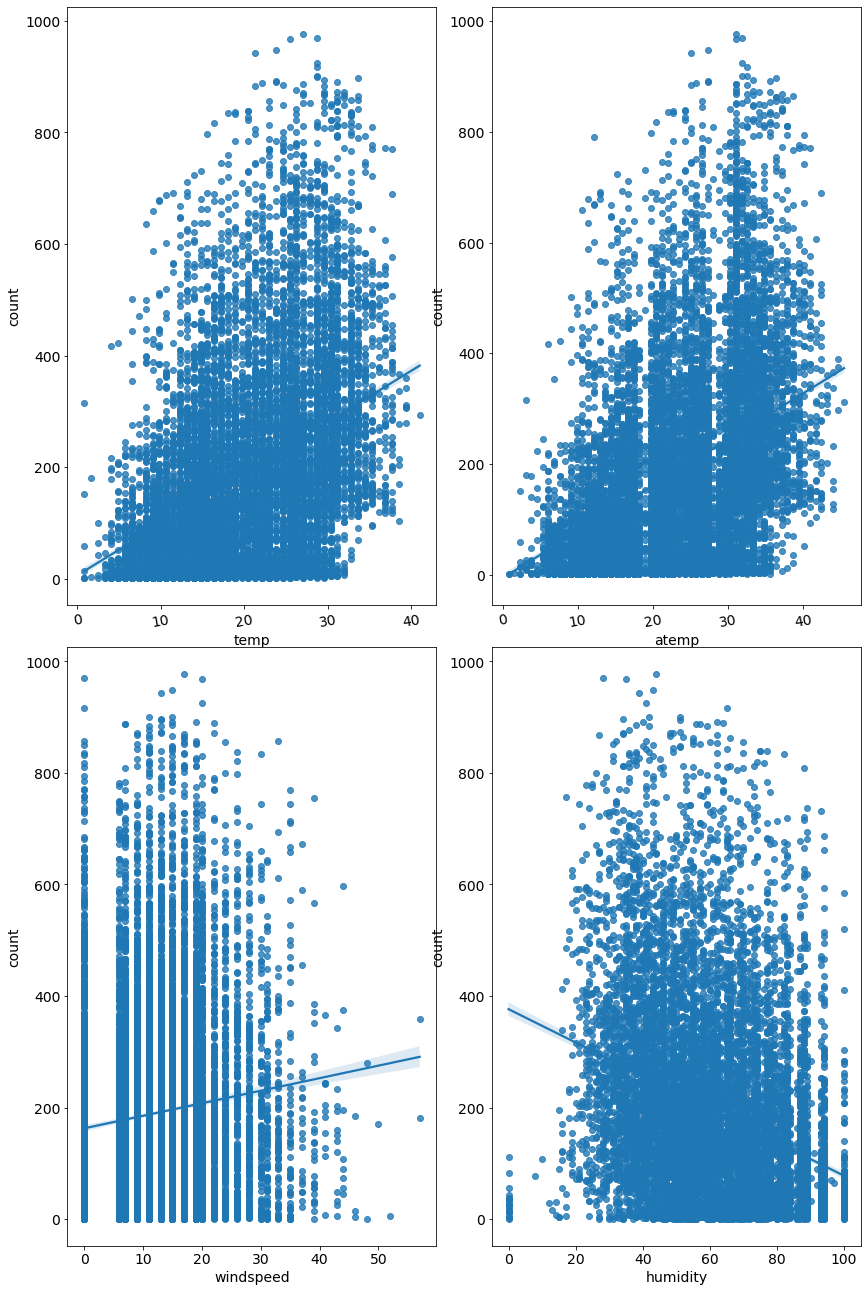

In [28]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 18)) # 2행 2열 12X18 사이즈 Figure 생성
plt.tight_layout() # 서브플롯 간 공간이 넉넉해짐

x = [['temp','atemp'],['windspeed','humidity']]
x = np.array(x)

for i in range(2):
    for j in range(2):
        sns.regplot(x=x[i,j], y='count', data=train, ax=axes[i, j]) # seaborn을 axes각 객체에 할당하려면 ax파라미터 사용
        axes[0, j].tick_params(axis='x', labelrotation=10) # axes[i, j]에 사용가능한 메서드가 따로 있음 : dir(axes[i,j])로 확인

 - 온도, 체감온도 높을수록 대여 수량 증가
 - 습도 낮을수록 대여 수량 증가
 - 풍속이 셀수록 대여 수량 증가 : 풍속 피처에 결측 값이 많기 때문
 - 풍속이 0인 데이터 많음 : 관측치가 없거나 오류
 - 결측 값이 많아 상관관계 파악 어려움 : 풍속 피처 삭제

### 히트맵
 - 수치형 데이터 간의 상관관계 파악


In [29]:
train[['temp','atemp','humidity','windspeed','count',]].corr() # 피처간 상관계수 파악

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


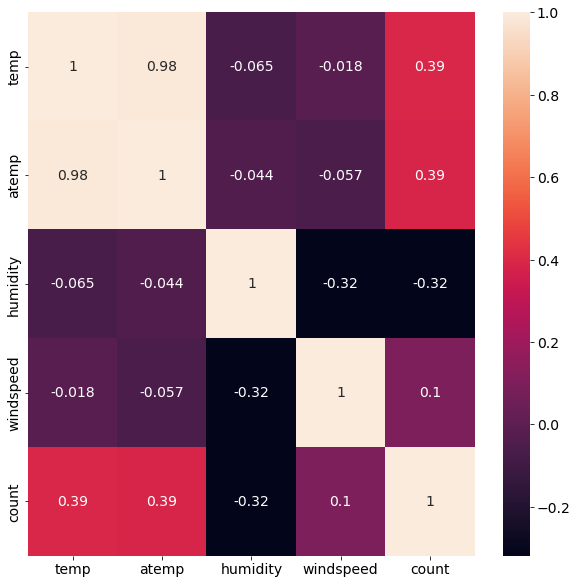

In [30]:
corrMat = train[['temp','atemp','humidity','windspeed','count',]].corr()
fig, axes = plt.subplots(figsize=(10,10))
sns.heatmap(corrMat, annot=True) # annot 파라미터 : 상관계수 숫자 표시

 - 상관계수 양수 : 양의 상관관계
 - 풍속(windspeed)과 대여수량(count)의 상관계수 0.1 : 매우 약해서 예측에 도움 안됨 → 피처 삭제

# 베이스라인 모델
 - 앞에서 파악한 피처들을 활용해 베이스라인 모델을 훈련
 - 삭제할 피처, 파생피처 등을 고려하여 피처 엔지니어링

In [31]:
import numpy as np
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

In [32]:
train = train[train['weather'] != 4] # 폭우, 폭설내리는 저녁 6시는 이상치 : 제거

# 데이터 합치기
 - 훈련/테스트 데이터셋에 같은 피처 엔지니어링 적용을 위해 두데이터셋 합침
 - concat()

In [33]:
all_data_temp = pd.concat([train, test])
all_data_temp

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [34]:
all_data_temp.shape

(17378, 12)

 - 총 17,378행인데 인덱스가 6,492까지 밖에 안보임
 - 훈련 데이터셋을 0부터 10885까지 매기고, 다시 0부터 6492까지 매김
 - 원래 데이터의 인덱스를 무시하고 이어 붙이기 : ignore_index=True 매개변수 전달

In [35]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


 - 테스트 데이터에 casual, registered 피처 및 count 타깃값이 없으므로 NaN 표시됨

### 파생 피처 추가

In [38]:
from datetime import datetime

# 날짜 생성 피처
all_data['date'] = all_data['datetime'].apply(lambda x : x.split()[0])
# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x : x.split()[0].split('-')[0])
# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x : x.split()[0].split('-')[1])
# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x : x.split()[1].split('-')[0])
# 요일 피처 생성
all_data['weekday'] = all_data['date'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d").weekday())

 - 훈련 데이터는 매달 1일부터 19일, 테스트 데이터는 20일 부터 월말까지 기록
 - 즉, 대여 수량을 예측할 때 일(day) 피처는 사용할 수 없다
 - minute, second 피처도 모든 기록에서 값이 같으므로 사용 할 필요 없다.

### 필요 없는 피처 제거
 - 테스트 데이터에는 없는 casual, registered 피처 삭제
 - datetime 피처는 인덱스 열할이므로 삭제
 - date 피처의 정보는 다른 피처(year, month, day)에 담겨 있기때문에 필요 없다.
 - season의 피처가 month의 대분류의 성격이므로 month피처도 필요 없다.
 - windspeed 피처는 대여수량과 상관관계가 약하므로 필요 없다.

In [40]:
drop_features = ['casual','registered','datetime','date','month','windspeed']
all_data = all_data.drop(drop_features, axis=1) # drop(['col1','col2','...'], axis=1)

### 데이터 나누기
 - 모든 피처 엔지니어링을 적용했으므로 훈련 데이터와 테스트 데이터를 나눔

In [41]:
X_train = all_data[~pd.isnull(all_data['count'])] # ~isnull() 값이 없지 않은가 → 값이 있는가
X_test = all_data[pd.isnull(all_data['count'])] # isnull() 값이 없는가

In [42]:
# 데이터셋에서 데이터와 타깃값을 나눠줌
X_train = X_train.drop(['count'], axis=1) # 훈련 데이터에서 타깃값 제거
X_test = X_test.drop(['count'], axis=1) # 테스트 데이터에서 타깃값 제거

y = train['count'] # 타깃값은 train에만 있음

In [43]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00:00:00,5
1,1,0,0,1,9.02,13.635,80,2011,01:00:00,5
2,1,0,0,1,9.02,13.635,80,2011,02:00:00,5
3,1,0,0,1,9.84,14.395,75,2011,03:00:00,5
4,1,0,0,1,9.84,14.395,75,2011,04:00:00,5


### 평가지표 계산 함수 작성
 - 훈련이 제대로 되었는지 확인하려면 평가 지표 필요
 - 본 경진대회 평가지표인 RMSLE를 계산하는 함수를 만들자

In [ ]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수 변환 : 타깃값으로 conunt가 아닌 log(count)를 사용 하기 때문(지수변환하면 count가 됨)
    # 타깃값이 정규분포를 따른다면 log(count) 안해도 됨
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그변환, 결측값0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))

    # RMSLE 계산
    output = np.sqrt(np.mean())